<a href="https://colab.research.google.com/github/LotanLevy/DOC/blob/master/jupyter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Enviroment settings**

In [ ]:
pip install tensorflow-gpu==2.3.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### **Usefull Functions**

In [5]:
import cv2
from PIL import Image
from tensorflow.keras.applications import mobilenet_v2, vgg16

"""
resize function for mnist data
"""
def resize(x, size=96):
    x_out = []
    for i in range(len(x)):
      img = x[i]
      if img.shape[-1] == 1:
        img = cv2.cvtColor(x[i], cv2.COLOR_GRAY2RGB)
      img = cv2.resize(img,dsize=(size,size))
      x_out.append(img)
    return np.array(x_out)

"""
Mobile net network faster then vgg but acheive worse results than vgg.
Now only work for fmnist
"""
def mobilenet_v2_preprocessing(input_data):
  return input_data.astype('float32')/ 255

"""
Should work for both mnist and imagenet test
"""
def vgg_preprocessing(input_data):
  # return vgg16.preprocess_input(resize(np.copy(input_data).astype('float32'), size=size))
    return vgg16.preprocess_input(np.copy(input_data.astype('float32')))

### **Dataloaders classes**

In [17]:
import os
import numpy as np 
from PIL import Image
from sklearn.model_selection import train_test_split

"""
Data loader for fmnist data (gets the full data and their labels in the constructor)
"""
class DataIter:
  def __init__(self, data, labels, batch_size, classes_num, shuffle=False, preprocess_func=lambda x:x):
    if labels is not None:
        assert(len(data) == len(labels))
        self.labels = np.array(labels)
    else:
      self.labels = None

    self.preprocess_func = preprocess_func

    self.data = data
    self.classes_num = classes_num
    self.batch_size = batch_size
    self.indices = np.arange(len(self.data)).astype(np.int)
    self.shuffle = shuffle
    self.on_epoch_end()

  def on_epoch_end(self):
    if self.shuffle:
      np.random.shuffle(self.indices)
    self.cur_idx = 0

  def next(self):
    relevant_indices = self.indices[self.cur_idx: self.cur_idx + self.batch_size]
    self.cur_idx += self.batch_size
    images = self.data[relevant_indices]
    if self.labels is not None:
      labels = self.labels[relevant_indices]
      labels = tf.keras.utils.to_categorical(labels, num_classes=self.classes_num)
    else:
      labels = None
    return resize(self.preprocess_func(images), size), labels

  def get_all_data(self, size=None):
    if size is None:
      size = len(self.data)
    return resize(self.preprocess_func(self.data[:size]), size), None

  def __len__(self):
    return len(self.data)


"""
Data iterator that loads the data from a path only when a batch called (next and get_all_data)
"""
class DirIter:
    def __init__(self, paths, labels, batch_size, input_size, classes_num, shuffle=False, preprocess_func=lambda x:x):
      if labels is not None:
        assert(len(paths) == len(labels))
        self.labels = np.array(labels)
      else:
        self.labels = None
      self.preprocess_func = preprocess_func

      self.paths = paths
      self.classes_num = classes_num
      self.batch_size = batch_size
      self.indices = np.arange(len(self.paths)).astype(np.int)
      self.input_size = input_size
      self.shuffle = shuffle
      self.on_epoch_end()

    def __len__(self):
      return len(self.paths)

    def on_epoch_end(self):
      if self.shuffle and len(self.indices) > 0:
        np.random.shuffle(self.indices)
      self.cur_idx = 0

    def load_img(self, image_path):
        image = Image.open(image_path, 'r')
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image = image.resize(self.input_size, Image.NEAREST)
        image = np.array(image).astype(np.float32)
        return np.expand_dims(image, axis=0)

    def next(self):
        relevant_indices = self.indices[self.cur_idx: self.cur_idx + self.batch_size]
        self.cur_idx += self.batch_size
        images = []
        images = np.concatenate([self.load_img(self.paths[i]) for i in relevant_indices])
        if self.labels is not None:
          labels = self.labels[relevant_indices]
          labels = tf.keras.utils.to_categorical(labels, num_classes=self.classes_num)
        else:
          labels = None
        return self.preprocess_func(images), labels

    def get_all_data(self, size=None):
      if size is None:
        size = len(self.paths)
      relevant_paths = [self.paths[i] for i in self.indices[:size]]
      images = np.concatenate([self.load_img(path) for path in relevant_paths])
      return self.preprocess_func(images), relevant_paths

    def has_next(self):
      return self.cur_idx + self.batch_size < len(self.indices)

    def set_cls2label_map(self, map):
        self.cls2label = map

    def write_data(self, output_path, loader_name):
      with open(os.path.join(output_path, loader_name + "_paths.txt"), 'w') as f:
        for p in self.paths:
          f.write(p + "\n")
      with open(os.path.join(output_path, loader_name + "_labels.txt"), 'w') as f:
        for l in self.labels:
          f.write(str(l) + "\n")

    @staticmethod
    def construct_with_files(path_file, label_file, batch_size, input_size, classes_num, shuffle=False, preprocess_func=lambda x:x):
      


"""
Data loader that loads data from a dir of sub dirs, each sub dir contains data of one class.
Works similarly to directory iterator, but it loads the data from a path only when a batch called (next and get_all_data)
"""
def get_iterators_by_root_dir(root_dir, batch_size, input_size, split_val, classes_num, shuffle=False):
    dirs = os.listdir(root_dir)
    length = len(max(dirs, key=len))

    for dir in dirs: # Handle the sort problem pads the clas num with '0'
        if len(dir) < length:
          zeros = "0" * (length - len(dir))
          new_name = zeros + dir

          os.rename(os.path.join(root_dir, dir), os.path.join(root_dir, new_name))
          print("old {}, new {}".format(dir, new_name))

    paths = []
    labels = []
    cls2label = dict()
    label_idx = 0
    for sub_dir in sorted(os.listdir(root_dir)):

        full_path = os.path.join(root_dir, sub_dir)
        if not os.path.isdir(full_path):
            continue
        cls2label[sub_dir] = label_idx
        for file in os.listdir(full_path):
            paths.append(os.path.join(full_path, file))
            labels.append(label_idx)
        label_idx += 1

    print(cls2label)


    assert len(paths) == len(labels)
    if len(cls2label) != classes_num:
        print("classes in directory doesn't match classes_num")

    if split_val > 0:
      X_train, X_test, y_train, y_test = train_test_split(paths, labels, test_size=split_val, shuffle=shuffle)
    else:
      X_train, X_test, y_train, y_test = paths, [], labels, []

    train_iter = DirIter(X_train, y_train, batch_size, input_size, classes_num, shuffle=True)
    val_iter = DirIter(X_test, y_test, batch_size, input_size, classes_num, shuffle=(True))

    train_iter.set_cls2label_map(cls2label)
    val_iter.set_cls2label_map(cls2label)
    return train_iter, val_iter




###**Dataset dataloaders constructors**

In [10]:
from keras.datasets import fashion_mnist
import numpy as np

def get_fmnist_data_loaders():
  # dataset
  (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
  x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
  x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

  #Splitting the into subsets data
  x_train_s, x_test_s, x_test_b = [], [], []
  x_ref, y_ref = [], []

  x_train_shape = x_train.shape
  #train data
  for i in range(len(x_train)):
      if y_train[i] == 7: #Sneakers is 7
          temp = x_train[i]
          x_train_s.append(temp.reshape((x_train_shape[1:])))
      else:
          temp = x_train[i]
          x_ref.append(temp.reshape((x_train_shape[1:])))
          y_ref.append(y_train[i])

  x_ref, y_ref = np.array(x_ref), np.array(y_ref)

  #test data
  for i in range(len(x_test)):
      if y_test[i] == 7: #Sneakers is 7
          temp = x_test[i,:,:,:]
          x_test_s.append(temp.reshape((x_train_shape[1:])))

      if y_test[i] == 9: #Boots is 9
          temp = x_test[i,:,:,:]
          x_test_b.append(temp.reshape((x_train_shape[1:])))

  #tdata loaders
  train_s_loader = DataIter(np.array(x_train_s), None, batchsize, classes, shuffle=True, preprocess_func=preprocessing_func)
  ref_loader = DataIter(np.array(x_ref), np.array(y_ref), batchsize, classes, shuffle=True, preprocess_func=preprocessing_func)

  test_s_loader = DataIter(np.array(x_test_s), None, batchsize, classes, preprocess_func=preprocessing_func)
  test_b_loader = DataIter(np.array(x_test_b), None, batchsize, classes, preprocess_func=preprocessing_func)
  return  train_s_loader, ref_loader, test_s_loader, test_b_loader


def get_imagenet_clatech_loaders(ref_path, tar_path, alien_path, batchsize, input_size, split_val, cls_num, shuffle=False):
  ref_loader, i1 = get_iterators_by_root_dir(ref_path, batchsize, input_size, 0, cls_num, shuffle=shuffle)
  train_s_loader, test_s_loader = get_iterators_by_root_dir(tar_path, batchsize, input_size, split_val, cls_num, shuffle=shuffle)
  test_alien_loader, i2 = get_iterators_by_root_dir(alien_path, batchsize, input_size, 0, cls_num, shuffle=shuffle)
  print(len(ref_loader), len(i1))
  print(len(train_s_loader), len(test_s_loader))
  print(len(test_alien_loader), len(i2))

  return  train_s_loader, ref_loader, test_s_loader, test_alien_loader

## **Run Settings**

In [18]:
import tensorflow as tf
import datetime

"""
Outputs directories
"""
# main output folder
output_path = "/content/drive/My Drive/Colab Notebooks/affordances/experiments/experiment_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if not os.path.exists(output_path):
  os.makedirs(output_path)
#check points folder
ckpt_path = os.path.join(output_path, "ckpts")
if not os.path.exists(ckpt_path):
  os.makedirs(ckpt_path)
#Logs folder
epochs_log_dir = os.path.join(os.path.join(output_path, "epochs_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
batchs_log_dir = os.path.join(os.path.join(output_path, "batchs_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))


# MobileNetV2
# size = 96
# preprocessing_func = mobilenet_v2_preprocessing
# first_trained_layer_name = "block_13_expand"
# alpha = 0.5 #for MobileNetV2
# network_constractor = lambda : tf.keras.applications.MobileNetV2(include_top=True, input_shape=(size, size, 3), alpha=alpha, weights='imagenet')


# VGG16
size = 224
preprocessing_func = vgg_preprocessing
first_trained_layer_name =  "block5_conv1"
network_constractor = lambda : tf.keras.applications.VGG16(include_top=True, input_shape=(size, size, 3), weights='imagenet')
test_size = 200



lambda_ = 0.1 #for compact loss

# fmnist data
# classes = 10
# batchsize = 2
# train_s_loader, ref_loader, test_s_loader, test_b_loader = get_fmnist_data_loaders()

# # imagenet clatech data
REFERENCE_PATH = "/content/drive/My Drive/Colab Notebooks/affordances/datasets/imagenet_val_splitted"
TARGET_PATH = "/content/drive/My Drive/Colab Notebooks/affordances/datasets/knife_target_data"
ALIEN_PATH = "/content/drive/My Drive/Colab Notebooks/affordances/datasets/tovisualize"
classes = 1000
batchsize = 2
split_val = 0.2

train_s_loader, ref_loader, test_s_loader, test_b_loader = get_imagenet_clatech_loaders(REFERENCE_PATH, TARGET_PATH, ALIEN_PATH, batchsize, (size,size), split_val, classes, shuffle=True)

train_s_loader.write_data(output_path, "target_train")
ref_loader.write_data(output_path, "reference_train")
test_s_loader.write_data(output_path, "target_test")
test_b_loader.write_data(output_path, "target_alien")




{'0000000000000000': 0, '0000000000000001': 1, '0000000000000002': 2, '0000000000000003': 3, '0000000000000004': 4, '0000000000000005': 5, '0000000000000006': 6, '0000000000000007': 7, '0000000000000008': 8, '0000000000000009': 9, '0000000000000010': 10, '0000000000000011': 11, '0000000000000012': 12, '0000000000000013': 13, '0000000000000014': 14, '0000000000000015': 15, '0000000000000016': 16, '0000000000000017': 17, '0000000000000018': 18, '0000000000000019': 19, '0000000000000020': 20, '0000000000000021': 21, '0000000000000022': 22, '0000000000000023': 23, '0000000000000024': 24, '0000000000000025': 25, '0000000000000026': 26, '0000000000000027': 27, '0000000000000028': 28, '0000000000000029': 29, '0000000000000030': 30, '0000000000000031': 31, '0000000000000032': 32, '0000000000000033': 33, '0000000000000034': 34, '0000000000000035': 35, '0000000000000036': 36, '0000000000000037': 37, '0000000000000038': 38, '0000000000000039': 39, '0000000000000040': 40, '0000000000000041': 41, '

# **Train**

Model build...
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56

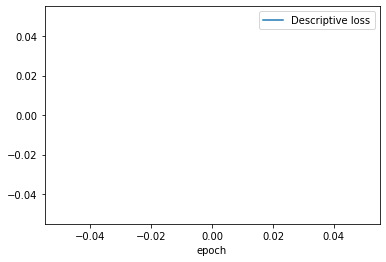

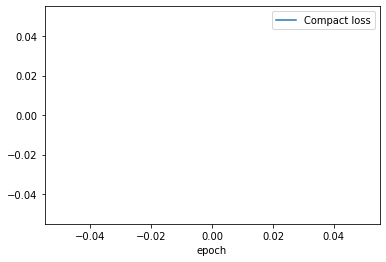

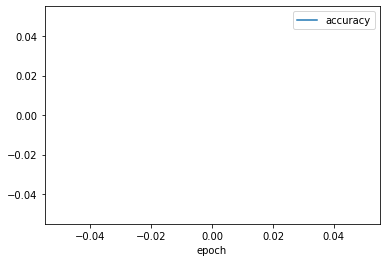

In [25]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

#Loss function
def compactness_loss(y_true, y_pred):
    n_dim = np.shape(y_pred)[0]  # number of features vecs
    k_dim = np.shape(y_pred)[1]  # feature vec dim
    lc = 1/(k_dim*n_dim)* n_dim**2 * K.sum((y_pred - K.mean(y_pred,axis=0))**2,axis=[1]) / ((n_dim-1)**2)
    return lc

#Learning
def train(target_dataloader, reference_dataloader, epoch_num):
    print("Model build...")

    network = network_constractor()
    #Freeze weight
    for layer in network.layers:
        if layer.name == first_trained_layer_name:
            break
        else:
            layer.trainable = False
    # Secondary network
    model_t = Model(inputs=network.input,outputs=network.layers[-2].output)
    # Reference network
    #Apply a Fully Connected Layer to R
    # prediction = Dense(classes, activation='softmax')(model_t.output) # for fmnist
    model_r = Model(inputs=model_t.input,outputs=network.layers[-1].output) # for imagenet
    
    #Compile
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    optimizer = SGD(lr=5e-5, decay=0.00005)
    model_r.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[train_accuracy])
    model_t.compile(optimizer=optimizer, loss=original_loss)

    # Prints run settings
    model_t.summary()
    model_r.summary()
    print("x_target is", len(target_dataloader),'samples')
    print("x_ref is",len(reference_dataloader),'samples')

    # run loggers
    epochs_writer = tf.summary.create_file_writer(logdir=epochs_log_dir)
    # batchs_writer = tf.summary.create_file_writer(logdir=batchs_log_dir)

    outputs = {"d loss": [], "c loss": [], "accuracy": []}
    loss, loss_c, epoch_accuracy = [], [], []

    print("training...")
    #Learning
    for epochnumber in range(epoch_num):
        lc, ld, accuracy = [], [], [] # epoch loaders
        for i in range(int(len(target_dataloader) / batchsize)):
            #Load data for batch size 
            batch_is_ready = False
            while not batch_is_ready:
              try:
                batch_target, _ = target_dataloader.next()
                batch_is_ready = True
              except: # some error in loading the data
                if not target_dataloader.has_next():
                    target_dataloader.on_epoch_end()
                continue

            batch_ref, batch_y = reference_dataloader.next()

            #target data
            #Get loss while learning
            lc.append(model_t.train_on_batch(batch_target, np.zeros((batchsize, 4096))))

            #reference data
            #Get loss while learning
            ref_output = model_r.train_on_batch(batch_ref, batch_y)
            ld.append(ref_output[0])
            accuracy.append(ref_output[1])
            count = (epochnumber * int(len(target_dataloader) / batchsize)) + i

            # if count % 50 == 0:
            #   with batchs_writer.as_default():
            #     tf.summary.scalar("d loss", np.mean(ld), step=count)
            #     tf.summary.scalar("c loss", np.mean(lc), step=count)
            #     tf.summary.scalar("accuracy", np.mean(accuracy), step=count)
            #   print("batch: {}: d loss {}, c loss {}, accuracy {}".format(count, np.mean(ld), np.mean(lc), np.mean(accuracy)))

        target_dataloader.on_epoch_end()
        reference_dataloader.on_epoch_end()

        outputs["d loss"].append(np.mean(ld))
        outputs["c loss"].append(np.mean(lc))
        outputs["accuracy"].append(np.mean(accuracy))
        with epochs_writer.as_default():
          for key in outputs:
            tf.summary.scalar(key, outputs[key][-1], step=epochnumber+1)
        print("epoch: {}: d loss {}, c loss {}, accuracy {}".format(epochnumber+1, outputs["d loss"][-1], outputs["c loss"][-1], outputs["accuracy"][-1] ))

        checkpoint_path = "weights_after_{}_epochs".format(epochnumber+1)
        network.save_weights(os.path.join(ckpt_path, checkpoint_path))



    #Result graph
    plt.plot(outputs["d loss"],label="Descriptive loss")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

    plt.plot(outputs["c loss"],label="Compact loss")
    plt.xlabel("epoch")
    plt.legend()
    plt.show() 

    plt.plot(outputs["accuracy"],label="accuracy")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()   

    return model_t



model = train(train_s_loader, ref_loader, 5)

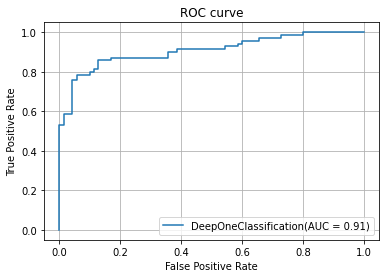

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

output_path = "/content/drive/My Drive/Colab Notebooks/affordances/experiments/experiment_20200924-092654"
ckpt_path = os.path.join(output_path, "ckpts")
roc_path = os.path.join(output_path, "roc_graphs")

if not os.path.exists(roc_path):
  os.makedirs(roc_path)

EPOCH_NUM = 5

model = network_constractor()
model.load_weights(os.path.join(ckpt_path, "weights_after_{}_epochs".format(EPOCH_NUM))).expect_partial()

X_train_s, relevant_paths_train_s = train_s_loader.get_all_data(size=40)
X_test_s, relevant_paths_test_s = test_s_loader.get_all_data(size=70)
X_test_b, relevant_paths_test_b = test_b_loader.get_all_data(size=70)

train = model.predict(X_train_s)
test_s = model.predict(X_test_s)
test_b = model.predict(X_test_b)

train = train.reshape((len(X_train_s),-1))
test_s = test_s.reshape((len(X_test_s),-1))
test_b = test_b.reshape((len(X_test_b),-1))

#Convert to 0-1
ms = MinMaxScaler()
train = ms.fit_transform(train)
test_s = ms.transform(test_s)
test_b = ms.transform(test_b)

# fit the model
clf = LocalOutlierFactor(n_neighbors=5)
y_pred = clf.fit(train)

#Abnormal score
Z1 = -clf._decision_function(test_s)
Z2 = -clf._decision_function(test_b)

#Drawing of ROC curve
y_true = np.zeros(len(test_s)+len(test_b))
y_true[len(test_s):] = 1 #0:Normal, 1：Abnormal

#Calculate FPR, TPR(, Threshould)
fpr, tpr, _ = metrics.roc_curve(y_true, np.hstack((Z1, Z2)))

#AUC
auc = metrics.auc(fpr, tpr)

#Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='DeepOneClassification(AUC = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.savefig(os.path.join(roc_path, "epoch_{}.png".format(EPOCH_NUM)))
plt.show()


In [20]:
results_path = os.path.join(output_path, "preds")

PRED_S_RESULTS_PATH = os.path.join(output_path, "pred_s_results.txt")
PRED_B_RESULTS_PATH = os.path.join(output_path, "pred_b_results.txt")


with open(PRED_S_RESULTS_PATH, "w") as rf:
  test_s_scores = list(zip(relevant_paths_test_s, Z1))
  for item in test_s_scores:
    rf.write("{}\n".format(item))

with open(PRED_B_RESULTS_PATH, "w") as rf:
  test_b_scores = list(zip(relevant_paths_test_b, Z2))
  for item in test_b_scores:
    rf.write("{}\n".format(item))


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
[39 35 33 11 13 10 28 20  2 15 23  4 37 24  9 38 31 29 25 12  6 17  5 27
 16 22 26 32  1 30  0  7 36 18  8  3 34 14 19 21]
190


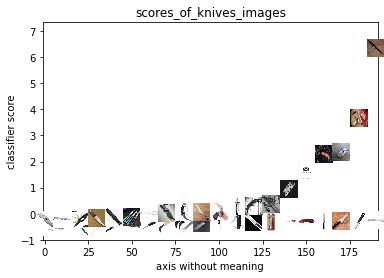

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
[39 50 64 35 33 44 11 13 48 42 69 10 63 58 68 28 20 40 51 55]
190


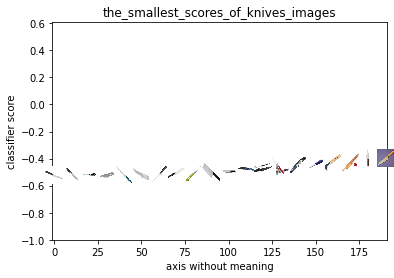

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
[12  2 28 22  6 33 24 17 29 31  1 14 25  4 23 27 10 37  9  3 34 11 32  0
 18 19 20 38 26 21  8 13 35 36 16 30 15  7 39  5]
190


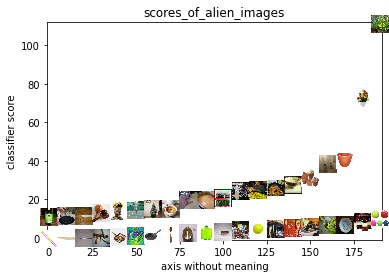

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
[50 12 47  2 57 54 68 28 22  6 33 24 17 62 29 31  1 56 53 14]
190


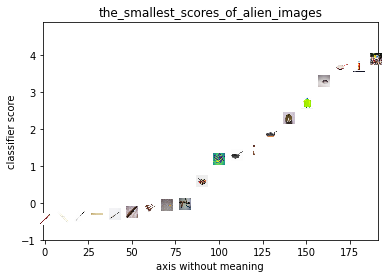

In [76]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import math
from skimage.transform import resize


def map_path_to_class(paths):
  paths2cls = dict()
  for path in paths:
    cls = path.split('/')[-2]
    paths2cls[path] = cls
  return paths2cls


def getImage(path, zoom):
  image = plt.imread(path)
  image = resize(image, (224, 224))
  return OffsetImage(image, zoom=zoom)


def create_images_graph(paths, scores, name, zoom, columns, max_objects=None):
  if max_objects is None:
    max_objects = len(scores)
  paths2cls = map_path_to_class(paths)
  indices =  np.argsort(scores)[:max_objects]
  scores = scores[indices]

  step = 10

  x = list(range(columns)) * math.ceil(len(indices)/float(columns))

  x = [step * i for i in x]
  

  print(x)
  x = x[:len(scores)]


  fig, ax = plt.subplots()
  # ax.scatter(x, scores[indices]) 

  print(indices[: max_objects])

  print(max(x))

  for i in range(max_objects):
    idx = indices[i]
    ab = AnnotationBbox(getImage(paths[idx], zoom), (x[i], scores[i]), frameon=False)
    ax.scatter(x[i], scores[i]) 
    ax.add_artist(ab)
  ax.update_datalim(np.column_stack([x, scores]))
  ax.autoscale()
  ax.set_ylim(-1,max(scores)+1)
  ax.set_xlim(-1,max(x)+1)
  plt.ylabel("classifier score")
  plt.xlabel("axis without meaning")
  plt.title(name)
  plt.savefig(os.path.join(output_path, "scores visualization_of_{}.png".format(name)), dpi=500)
  plt.show()



create_images_graph(relevant_paths_test_s[:40], Z1[:40], "scores_of_knives_images", 0.08, 20)
create_images_graph(relevant_paths_test_s, Z1, "the_smallest_scores_of_knives_images", 0.08, 20, 20)
create_images_graph(relevant_paths_test_b[:40], Z2[:40], "scores_of_alien_images", 0.08, 20)
create_images_graph(relevant_paths_test_b, Z2, "the_smallest_scores_of_alien_images", 0.05, 20, 20)


In [ ]:
from sklearn.manifold import TSNE


new_network = network_constractor()




# new_mobile = tf.keras.applications.MobileNetV2(include_top=True, input_shape=(size, size, 3), alpha=alpha, weights='imagenet')

untrained_test_s = new_network.predict(X_test_s)
untrained_test_b = new_network.predict(X_test_b)

untrained_test_s_embedded = TSNE(n_components=2).fit_transform(test_s)
untrained_test_b_embedded = TSNE(n_components=2).fit_transform(test_b)

plt.figure()
plt.scatter(untrained_test_s_embedded[:, 0],untrained_test_s_embedded[:,1], label="Sneakers")
plt.scatter(untrained_test_b_embedded[:, 0],untrained_test_b_embedded[:,1], label="Boots")
plt.legend()
plt.grid(True)
plt.show()


test_s_embedded = TSNE(n_components=2).fit_transform(test_s)
test_b_embedded = TSNE(n_components=2).fit_transform(test_b)

plt.figure()
plt.scatter(test_s_embedded[:, 0],test_s_embedded[:,1], label="Sneakers")
plt.scatter(test_b_embedded[:, 0],test_b_embedded[:,1], label="Boots")
plt.legend()
plt.grid(True)
plt.show()
